In [4]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import datasets,decomposition,manifold
from andylearn import mnist, KNNneighbor
import scipy
import math
import pylab
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
#%pylab inline

In [43]:
def LPP(data, k, d, ):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-(np.linalg.norm(data[j]-data[i],ord=2))/2)
            W[j, i] = W[i, j]  
    for i in range(N):
        for j in neibors[i].A[0]:
            D[i, i] +=W[i, j]  
    
    # Step 3
    # mappings 
    
    L=D-W
    D_ = np.dot(np.dot(data.T, D), data)
    D_ = D_ + 0.000000001 * np.eye(Dim)
    L_ = np.dot(np.dot(data.T, L), data)
    eigenValues, eigenVectors=scipy.linalg.eig(np.dot(D_.I, L_))
    eigenValuesIndex = np.argsort(eigenValues)
    mapping = eigenVectors[:, eigenValuesIndex[0:d]].T
    
    return mapping

In [44]:
data=scipy.io.loadmat("data/orl_faces/32_32/ORL_32x32.mat")
face = data['fea']/256
label = data['gnd']

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


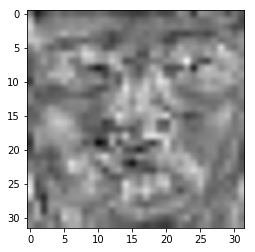

In [45]:
def LPP_faces():
    matfn = 'data/orl_faces/32_32/2Train/4.mat'
    index = scipy.io.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = LPP(trainface, 10, 8)
    tmp=mapping[0]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
LPP_faces()

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


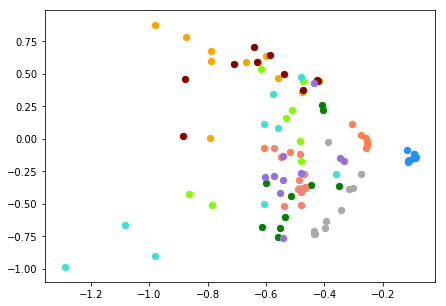

In [46]:
def LPP_ORL_scatters():
    # the first 100 samples
    face100 = np.squeeze(face)[:100]
    label100 = label.reshape(400)[:100]
    mapping = LPP(face100, 10, 2)
    low_data = np.dot(mapping, face100.T).T
    
    fig = plt.figure(figsize=(7,5))
    plotwindow = fig.add_subplot(111)
    a = np.array(low_data)

    # draw the scatters
    color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
    for j in range(len(low_data)):
        plt.scatter(a[j][0], a[j][1],s=40, c=color[label100[j]-1])
    plt.show()
LPP_ORL_scatters()

In [75]:
def PCA(data,dimensions):
    '''
    data is the original data set，rows are samples of data,columns are the features
    '''

    # making data zero-means
    average = np.mean(data,0)
    data_zero = np.mat(data-average)
    
    #covariance
    covariance = np.cov(data_zero,rowvar=False)
    
    #eigenvalues
    eig_var,eig_vec = np.linalg.eig(covariance)
    
    
    #from the numpy doc, the eig_var may not be ordered.
    sort_eig = np.argsort(-eig_var)
    #return the index that make a sorted array

    #so we got the sorted eig_var
    sort_eig = sort_eig[:dimensions]
    principal_vec = np.mat(eig_vec[:,sort_eig])
    
    return principal_vec, np.dot(data_zero, principal_vec)

def Laplacianfaces(data, k, d, t):
    
    data = np.matrix(data)
    N = data.shape[0]
    D = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            D[i, i] +=W[i, j]  
            
    
    # Step 3
    # mappings 
    
    L=D-W
    X = np.dot(np.dot(data.T, D), data)
    X = np.dot(X.I,np.dot(np.dot(data.T, L), data))
    eigenValues, eigenVectors=np.linalg.eig(X)
    eigenValuesIndex = np.argsort(eigenValues)
    mapping = np.mat(eigenVectors[:, eigenValuesIndex[0:d]])
    
    mapping_PCA = PCA(data, d)
    
    return np.dot(mapping_PCA, mapping.T)


In [37]:
def LP_faces():
    matfn = 'faces/3Train/2.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = Laplacianfaces(trainface, 5, 8, 10)
    tmp=mapping[2]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
#LP_faces()

In [38]:
def LPscore(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'faces/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
        trainface = face[trainIdx]
        trainlabel = label[trainIdx].reshape(l*40,1)
        trainface = np.squeeze(trainface) 
        
        testface = face[testIdx]
        testlabel = label[testIdx].reshape(400-l*40,1)
        testface = np.squeeze(testface)  
       
        mapping = Laplacianfaces(trainface, 10, 150, 10)
        traindata = np.dot(mapping, trainface.T)
        testdata = np.dot(mapping, testface.T)
        s+=knn_score(traindata.T, trainlabel, testdata.T, testlabel)
    return s/50

# LP_score = LPscore(3)
# print(LP_score)

In [99]:
def twoD_LPP(data, k, n_1, n_2, l_1, l_2):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-(np.linalg.norm(data[j]-data[i],ord=2))/2)
            W[j, i] = W[i, j]  
   
    
    # Step 3
    # mappings 
    
    # initial L
    L = np.ones((n_1, l_1))
    
    for i in range(N):
        A_i = data[i, :].reshape((n_1, n_2))
        for j in range(N):
            A_j = data[j, :].reshape((n_1, n_2))
            R_L = W[i, j]*np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))
            R_R = np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))
            
    eigenValues, eigenVectors=scipy.linalg.eig(R_L, R_R)
    eigenValuesSort=np.argsort(eigenValues)
    R=np.mat(eigenVectors[:,eigenValuesSort[0:l_2]])
    
    for i in range(N):
        A_i = data[i, :].reshape((n_1, n_2))
        for j in range(N):
            A_j = data[j, :].reshape((n_1, n_2))
            L_L = W[i, j]*np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))
            L_R = np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))

    eigenValues, eigenVectors=scipy.linalg.eig(L_L, L_R)
    eigenValuesSort=np.argsort(eigenValues)
    L=np.mat(eigenVectors[:,eigenValuesSort[0:l_1]])
    
    return L, R

In [100]:
def Kernel_LPP(data, k, d):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-(np.linalg.norm(data[j]-data[i],ord=2))/2)
            W[j, i] = W[i, j]  
    for i in range(N):
        for j in neibors[i].A[0]:
            D[i, i] +=W[i, j]  
    
    # Step 3
    # mappings 
    K=np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = math.exp(-(np.linalg.norm(data[j]-data[i],ord=2))/2)
    
    
    L=D-W
    ei_L=np.dot(np.dot(K, L), K)
    ei_R=np.dot(np.dot(K, D), K)
    eigenValues, eigenVectors=scipy.linalg.eig(ei_L, ei_R)
    eigenValuesSort=np.argsort(eigenValues)
    mapping = eigenVectors[:, eigenValuesSort[0:d]]
    
    return mapping, K

In [101]:
def LPPscore(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'orl_faces/32_32/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
        

##LPP      
#         trainface = np.squeeze(face[trainIdx])
#         trainlabel = np.squeeze(label[trainIdx])
#         testface = np.squeeze(face[testIdx])
#         testlabel = np.squeeze(label[testIdx]) 
#         mapping = LPP(trainface, 2, 100)
#         traindata = np.dot(mapping, trainface.T)
#         testdata = np.dot(mapping, testface.T)
#         tmp=knn_score(traindata.T, trainlabel, testdata.T, testlabel)
        
## 2D LPP
        mapping, face_pca = PCA(np.squeeze(face), 225)
        
        trainface = np.squeeze(face_pca[trainIdx])
        trainlabel = np.squeeze(label[trainIdx])
        testface = np.squeeze(face_pca[testIdx])
        testlabel = np.squeeze(label[testIdx])

       
        L, R= twoD_LPP(trainface, 2, 15, 15, 7, 7)
        
        traindata = []
        testdata = []
        for i in range(trainface.shape[0]):
            traindata.append(np.dot(np.dot(L.T, trainface[i].reshape(15, 15)), R).A[0])
        for i in range(testface.shape[0]):
            testdata.append(np.dot(np.dot(L.T, testface[i].reshape(15, 15)), R).A[0])
        
        tmp=knn_score(traindata, trainlabel, testdata, testlabel)

## kernel
#         trainface = np.squeeze(face[trainIdx])
#         trainlabel = np.squeeze(label[trainIdx])
#         testface = np.squeeze(face[testIdx])
#         testlabel = np.squeeze(label[testIdx])
       
#         mapping, K_train= Kernel_LPP(trainface, 10, 50)

#         K_test = np.zeros((trainface.shape[0], testface.shape[0]))
#         for i in range(trainface.shape[0]):
#             for j in range(testface.shape[0]):
#                 K_test[i, j]=math.exp(-(np.linalg.norm(trainface[i]-testface[j],ord=2))/2)
        
#         traindata = np.dot(mapping.T, K_train)
#         testdata = np.dot(mapping.T, K_test)
#         tmp=knn_score(traindata.T, trainlabel, testdata.T, testlabel)
        
        
        print(tmp)
        s+=tmp
    return s/50

LPP_score = LPPscore(6)
print("s", LPP_score)

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.78125
0.775
0.8125
0.825
0.8
0.825
0.75625
0.8125
0.7875
0.8125
0.79375
0.7875
0.79375
0.775
0.725
0.75625
0.7375
0.79375
0.775
0.8
0.81875
0.76875
0.74375
0.75625
0.7625
0.75625
0.78125
0.7875
0.7625
0.7875
0.76875
0.78125
0.76875
0.76875
0.76875
0.80625
0.75
0.78125
0.7875
0.7875
0.7625
0.8
0.81875
0.7875
0.775
0.75
0.78125
0.725
0.74375
0.775
s 0.77875
